Basic script to visualize the shedding curve utilized in the INSIDe demonstrator

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [5]:
plot_path = f"../plots/shedding_model/"

In [3]:

class Infection:
    def __init__(self):
        self.t_E = 3
        self.infectious_days_of_t_E = 0.01 * self.t_E
        self.t_C = 2.2
        self.t_I = 7
        self.t_H = 0
        self.t_ICU = 0
        self.viral_load_peak = 8.1
        self.viral_load_incline = 2.0
        self.viral_load_decline = -0.17
        self.viral_load_end = int(self.viral_load_peak / self.viral_load_incline
                                  - self.viral_load_peak / self.viral_load_decline)
        self.alpha = -7.0
        self.beta = 1.0
        self.t_infected = self.t_E + self.t_C + self.t_I + self.t_H + self.t_ICU

    def update_t_infected(self):
        self.t_infected = self.t_E + self.t_C + self.t_I + self.t_H + self.t_ICU

    def get_viral_load(self, t):
        # peak is reached after peak/incline days
        if (t <= self.viral_load_end):
            if (t <= self.viral_load_peak / self.viral_load_incline):
                return self.viral_load_incline * t
            else:
                return self.viral_load_peak + self.viral_load_decline * (t - self.viral_load_peak / self.viral_load_incline)
        return 0

    def get_infectivity(self, t):
        # the infectivity is zero for t_E - 1.3. The intuition behind that is, that the last 1.3 days of being exposed,
        # a person already starts to get infectious/shed viral load
        time_shift = self.t_E - self.infectious_days_of_t_E
        # for the first time_shift days after transmission, the infectivity is zero
        if (t <= time_shift or t > self.t_infected):
            return 0
        # curve scaling
        # 1. t is shifted by time_shift: t = t-time_shift
        # 2. viral load curve is scaled by time a person is infected:
        # scaling_factor = viral_load_time / time_infected; t = scaling_factor * t
        # COMMENT: t_E is part of time_infected i.e. the curve is scaled for an interval that ist time_shift longer
        #           than the person is actually infected. Therefore the viral load is not zero at the end of the infection,
        #           but there is a small jump at the end
        tau = self.viral_load_end / self.t_infected
        t_scaled = tau * (t - time_shift)
        infectivity = 1 / \
            (1 + math.exp(-(self.alpha + self.beta * self.get_viral_load(t_scaled))))
        if (self.t_H > 0):
            return infectivity
        else:
            return 0.75 * infectivity

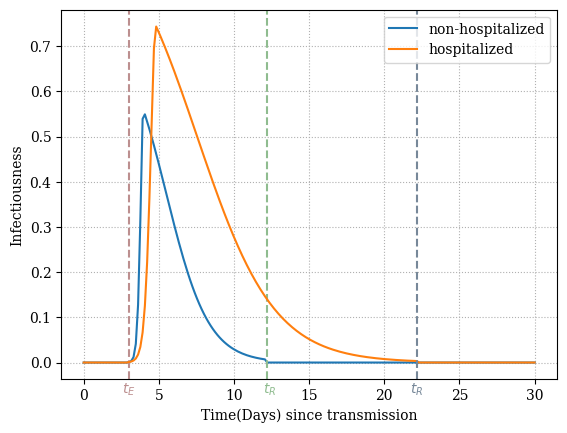

In [6]:

infection = Infection()
time = np.linspace(0, 30, 200)
y = [infection.get_infectivity(t) for t in time]

fig, ax = plt.subplots()
ax.plot(time, y, label='non-hospitalized')
ax.axvline(x=infection.t_E, linestyle="--", color="rosybrown")
plt.figtext(0.22, 0.08, '$t_E$', color="rosybrown")
ax.axvline(x=infection.t_infected, linestyle="--", color="darkseagreen")
plt.figtext(0.44, 0.08, '$t_R$', color="darkseagreen")

infection.t_H = 10
infection.update_t_infected()
y = [infection.get_infectivity(t) for t in time]
ax.plot(time, y, label='hospitalized')
ax.axvline(x=infection.t_infected, linestyle="--", color="lightslategrey")
plt.figtext(0.67, 0.08, '$t_R$', color="lightslategrey")

plt.legend()
ax.grid(linestyle='dotted')
plt.xlabel('Time (Days) since transmission')
plt.ylabel('Infectiousness')
plt.savefig(f'{plot_path}/infectiousness.png')


In [9]:

class Shedding:
    def __init__(self, shedding_type, t_infected = (3, 2.2, 7, 0, 0)):
        # Duration in days of exposed
        # self.t_E = 3
        # Duration of the other infected states
        self.t_E, self.t_C, self.t_I, self.t_H, self.t_ICU = t_infected
        self.infectious_days_of_t_E = 0.01 * self.t_E
        
        # self.t_C = 2.2 # carrier (non-symptomatic infected)
        # self.t_I = 7 # symptomatic infected
        # self.t_H = 0 # hospitalized (severe infected)
        # self.t_ICU = 0 # ICU (critical)
        self.viral_load_peak = 8.1
        self.viral_load_incline = 2.0
        self.viral_load_decline = -0.17
        self.viral_load_end = int(self.viral_load_peak / self.viral_load_incline
                                  - self.viral_load_peak / self.viral_load_decline)
        self.c_1 = -7.0
        self.c_2 = 1.0
        self.t_infected = self.t_E + self.t_C + self.t_I + self.t_H + self.t_ICU
        # the infectivity is zero for t_E - 1.3. The intuition behind that is, that the last 1.3 days of being exposed,
        # a person already starts to get infectious/shed viral load
        self.time_shift = self.t_E - self.infectious_days_of_t_E

        if shedding_type=="infectivity":
            self.s_sc = 1
            self.t_s_end = self.t_infected
        elif shedding_type=="wastewater_shedding":
            self.s_sc = 10**(7.1)
            self.t_s_end = self.t_infected + self.time_shift
        self.shedding_type = shedding_type

    def update_t_infected(self, t_infected):
        self.t_E, self.t_C, self.t_I, self.t_H, self.t_ICU = t_infected
        self.t_infected = self.t_E + self.t_C + self.t_I + self.t_H + self.t_ICU
        self.time_shift = self.t_E - self.infectious_days_of_t_E

        if self.shedding_type=="infectivity":
            self.t_s_end = self.t_infected
        elif self.shedding_type=="wastewater_shedding":
            self.t_s_end = self.t_infected + self.time_shift


    def get_viral_load(self, t):
        # peak is reached after peak/incline days
        if (t <= self.viral_load_end):
            if (t <= self.viral_load_peak / self.viral_load_incline):
                return self.viral_load_incline * t
            else:
                return self.viral_load_peak + self.viral_load_decline * (t - self.viral_load_peak / self.viral_load_incline)
        return 0

    def get_shedding(self, t):
        
        # for the first time_shift days after transmission, the infectivity is zero
        if (t <= self.time_shift or t > self.t_s_end):
            return 0
        # curve scaling
        # 1. t is shifted by time_shift: t = t-time_shift
        # 2. viral load curve is scaled by time a person is infected:
        # scaling_factor = viral_load_time / time_infected; t = scaling_factor * t
        # COMMENT: t_E is part of time_infected i.e. the curve is scaled for an interval that ist time_shift longer
        #           than the person is actually infected. Therefore the viral load is not zero at the end of the infection,
        #           but there is a small jump at the end
        tau = self.viral_load_end / self.t_infected
        t_scaled = tau * (t - self.time_shift)
        shedding = 1 / \
            (1 + math.exp(-(self.c_1 + self.c_2 * self.get_viral_load(t_scaled))))
        if (self.t_H > 0):
            return shedding
        else:
            return 0.75 * shedding

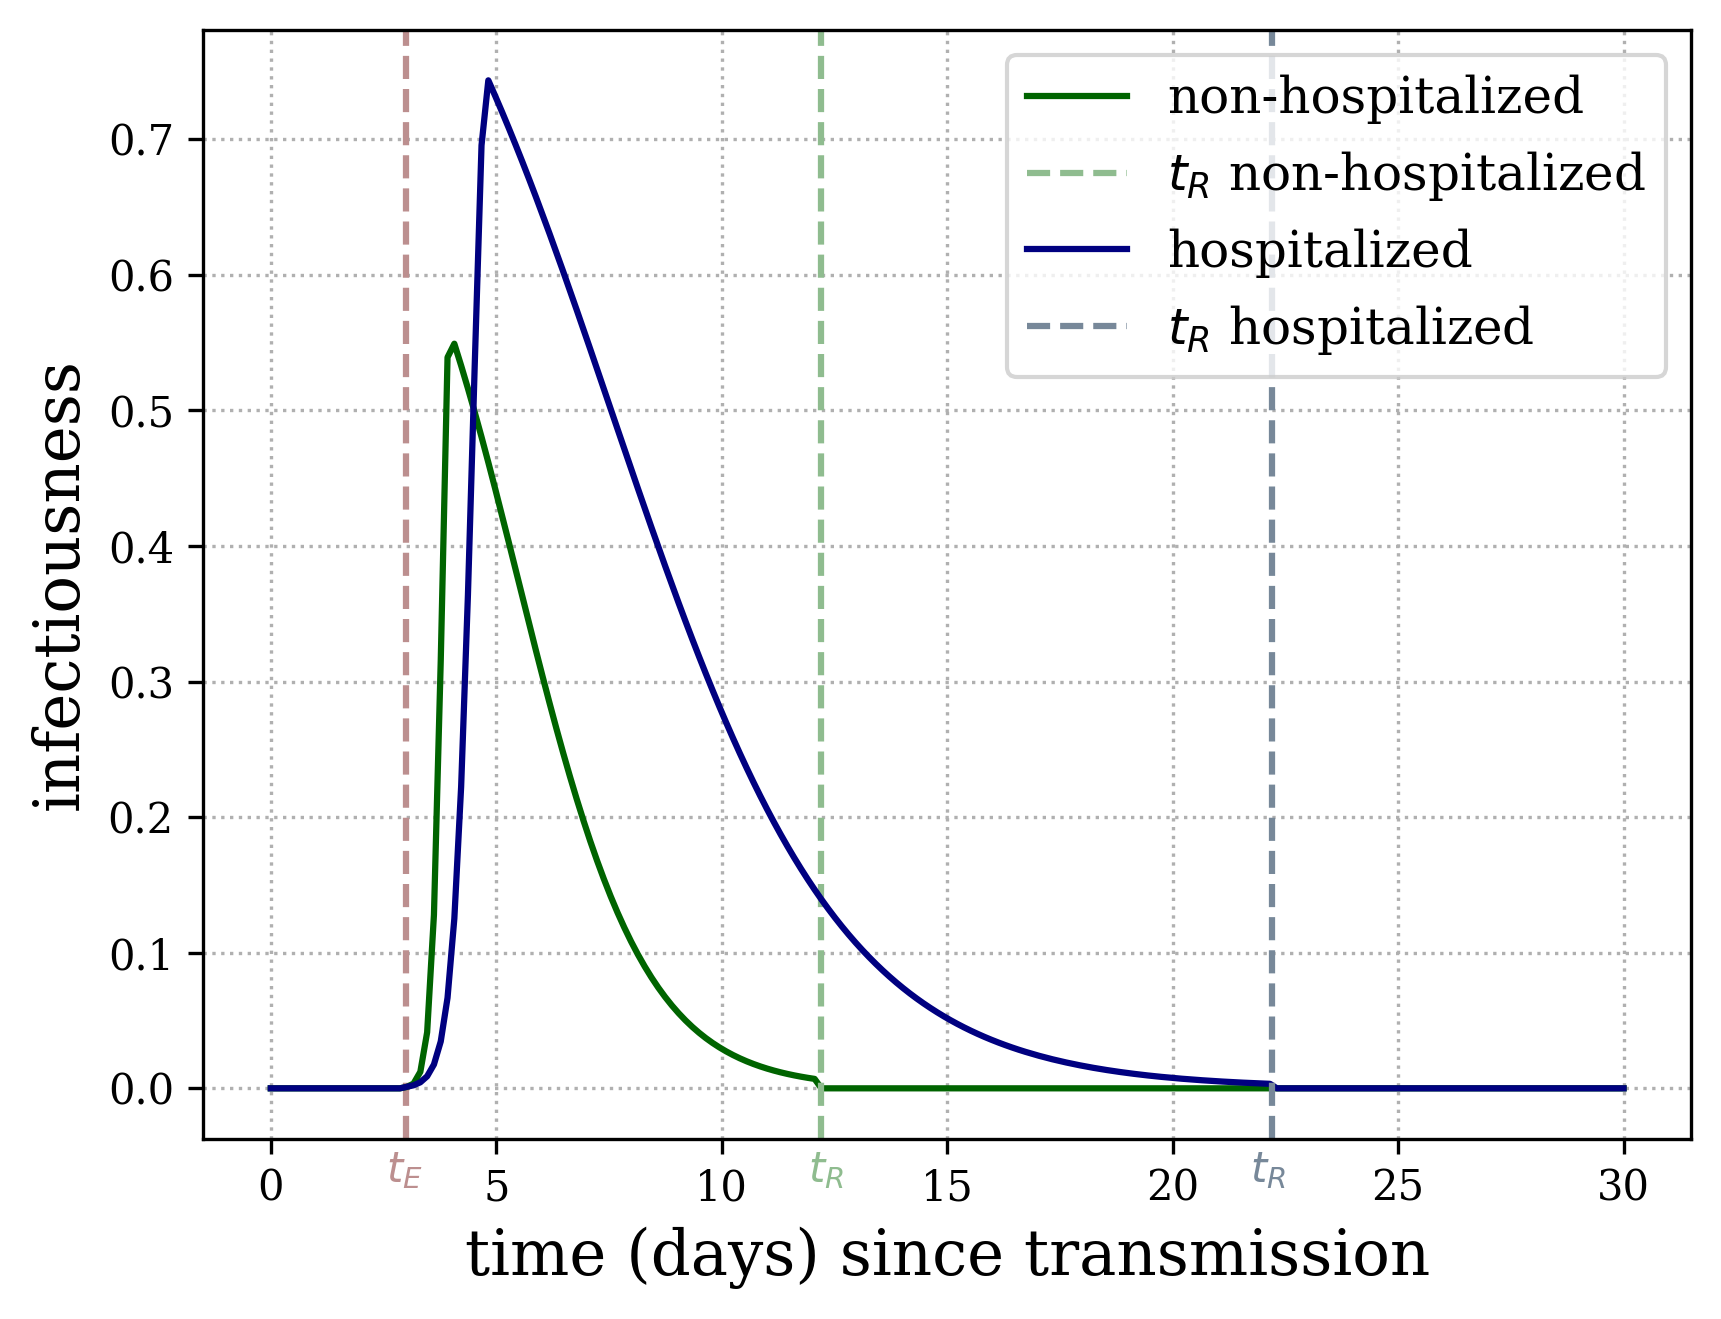

In [10]:

infection = Shedding("infectivity", t_infected = (3, 2.2, 7, 0, 0))
time = np.linspace(0, 30, 200)
y = [infection.get_shedding(t) for t in time]

fig, ax = plt.subplots(dpi=300)
ax.axvline(x=infection.t_E, linestyle="--", color="rosybrown")
ax.plot(time, y, label='non-hospitalized', color="darkgreen")
plt.figtext(0.22, 0.08, '$t_E$', color="rosybrown")
ax.axvline(x=infection.t_infected, linestyle="--", color="darkseagreen", label="$t_R$ non-hospitalized")
plt.figtext(0.44, 0.08, '$t_R$', color="darkseagreen")

infection.update_t_infected(t_infected = (3, 2.2, 7, 10, 0))
y = [infection.get_shedding(t) for t in time]
ax.plot(time, y, label='hospitalized', color="navy")
ax.axvline(x=infection.t_infected, linestyle="--", color="lightslategrey", label="$t_R$ hospitalized")
plt.figtext(0.67, 0.08, '$t_R$', color="lightslategrey")

plt.legend(fontsize=12)
ax.grid(linestyle='dotted')
plt.xlabel('time (days) since transmission', fontsize=15)
plt.ylabel('infectiousness', fontsize=15)
plt.savefig(f'{plot_path}/infectiousness.png')

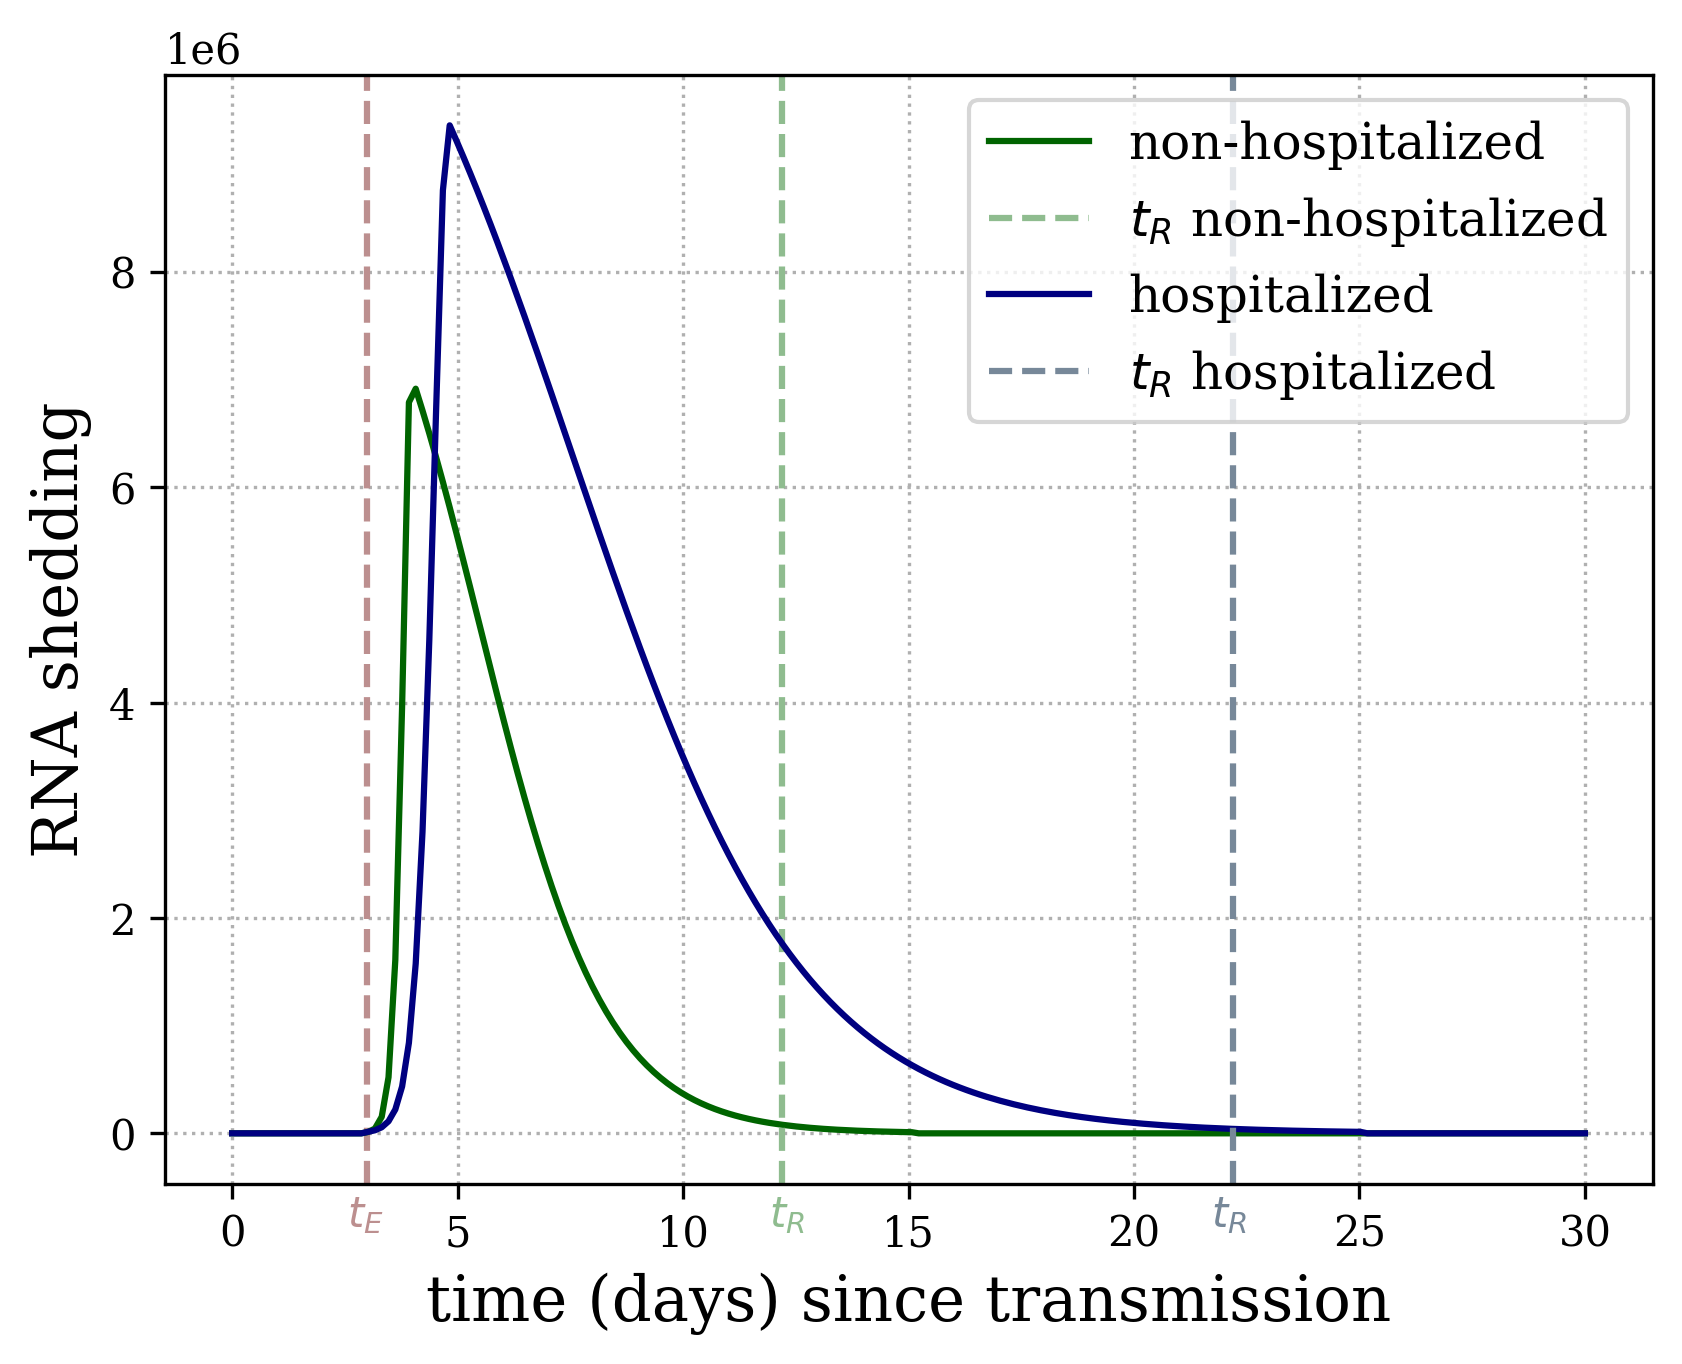

In [11]:

infection = Shedding("wastewater_shedding", t_infected = (3, 2.2, 7, 0, 0))
time = np.linspace(0, 30, 200)
y = [infection.get_shedding(t)*10**(7.1) for t in time]

fig, ax = plt.subplots(dpi=300)
ax.axvline(x=infection.t_E, linestyle="--", color="rosybrown")
ax.plot(time, y, label='non-hospitalized', color="darkgreen")
plt.figtext(0.22, 0.08, '$t_E$', color="rosybrown")
ax.axvline(x=infection.t_infected, linestyle="--", color="darkseagreen", label="$t_R$ non-hospitalized")
plt.figtext(0.44, 0.08, '$t_R$', color="darkseagreen")

infection.update_t_infected(t_infected = (3, 2.2, 7, 10, 0))
y = [infection.get_shedding(t)*10**(7.1) for t in time]
ax.plot(time, y, label='hospitalized', color="navy")
ax.axvline(x=infection.t_infected, linestyle="--", color="lightslategrey", label="$t_R$ hospitalized")
plt.figtext(0.67, 0.08, '$t_R$', color="lightslategrey")

plt.legend(fontsize=12)
ax.grid(linestyle='dotted')
plt.xlabel('time (days) since transmission', fontsize=15)
plt.ylabel('RNA shedding', fontsize=15)
plt.savefig(f'{plot_path}/wastewater_shedding.png')

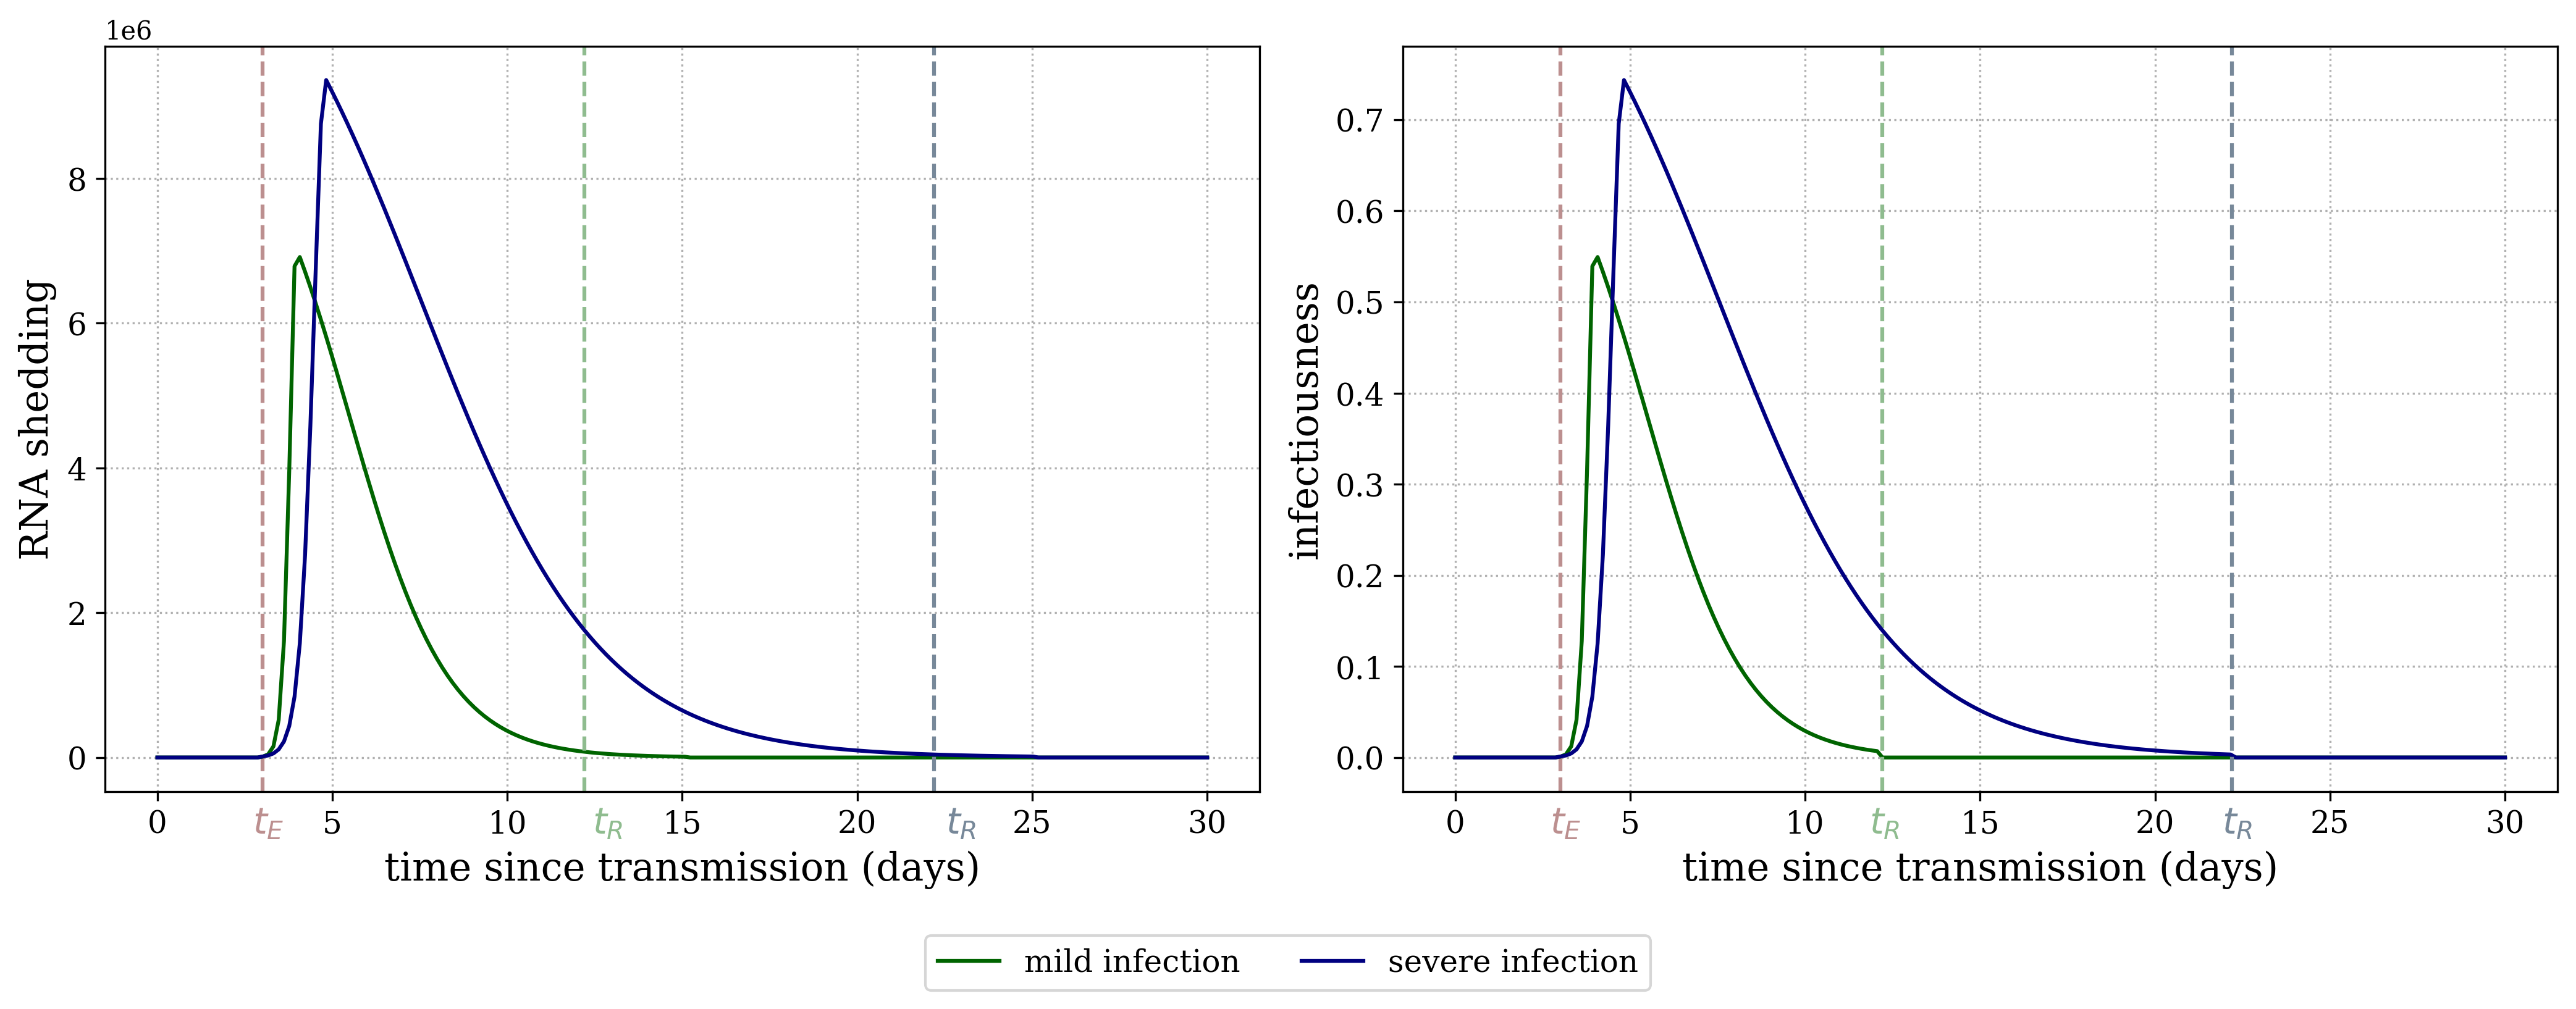

In [12]:
import matplotlib.pyplot as plt

# Data for plotting
x = [1, 2, 3, 4, 5]
y2 = [1, 4, 6, 8, 10]


infection = Shedding("wastewater_shedding", t_infected = (3, 2.2, 7, 0, 0))
time = np.linspace(0, 30, 200)
y = [infection.get_shedding(t)*10**(7.1) for t in time]


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=300)

# left plot
ax1.axvline(x=infection.t_E, linestyle="--", color="rosybrown")
ax1.plot(time, y, label='mild infection', color="darkgreen")
plt.figtext(0.101, 0.09, '$t_E$', color="rosybrown", fontsize=14)
ax1.axvline(x=infection.t_infected, linestyle="--", color="darkseagreen")# , label="$t_R$ mild infection")
ax1.grid(linestyle='dotted')
ax1.set_xlabel('time since transmission (days)', fontsize=15)
ax1.set_ylabel('RNA shedding', fontsize=15)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
plt.figtext(0.232, 0.09, '$t_R$', color="darkseagreen", fontsize=14)

infection.update_t_infected(t_infected = (3, 2.2, 7, 10, 0))
y = [infection.get_shedding(t)*10**(7.1) for t in time]
ax1.plot(time, y, label='severe infection', color="navy")
ax1.axvline(x=infection.t_infected, linestyle="--", color="lightslategrey")# , label="$t_R$ severe infection")
plt.figtext(0.368, 0.09, '$t_R$', color="lightslategrey", fontsize=14)


# Plot 2
infection = Shedding("infectivity", t_infected = (3, 2.2, 7, 0, 0))
time = np.linspace(0, 30, 200)
y = [infection.get_shedding(t) for t in time]
ax2.axvline(x=infection.t_E, linestyle="--", color="rosybrown")
ax2.plot(time, y, color="darkgreen")
plt.figtext(0.601, 0.09, '$t_E$', color="rosybrown", fontsize=14)
ax2.axvline(x=infection.t_infected, linestyle="--", color="darkseagreen")
ax2.grid(linestyle='dotted')
ax2.set_xlabel('time since transmission (days)', fontsize=15)
ax2.set_ylabel('infectiousness', fontsize=15)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
plt.figtext(0.724, 0.09, '$t_R$', color="darkseagreen", fontsize=14)

infection.update_t_infected(t_infected = (3, 2.2, 7, 10, 0))
y = [infection.get_shedding(t) for t in time]
ax2.plot(time, y, color="navy")
ax2.axvline(x=infection.t_infected, linestyle="--", color="lightslategrey")
plt.figtext(0.86, 0.09, '$t_R$', color="lightslategrey", fontsize=14)



# Create a single legend for both subplots
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Place the legend
fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig(f'{plot_path}/infectivity_and_RNA_shedding.png', bbox_inches='tight')

plt.show()